## Heart Attack Prediction Model 
## Preproceessing - Feature Engineering 
## Modeling - Baseline Modeling 

---


## Author: Will Wu

## Date: 2025-03-14
---

## **Table of Contents** ##
1. [Setup and Load Data](#1)
2. [Feature Engineering](#2)
    - [Binning Data - `bmi`](#2a)

3.  [Data Preparation](#3)
    - [Binary Encoding](#3a)
    - [Train-Validation-Test-Split](#3b)
    - [One-Hot Encoding](#3c)
    - [Handling Class Imbalance](#3d)
    - [Feature Scaling](#3e)
    - [Feature Selection](#3f)
    - [Reducing Dimensionality using PCA](#3f)
     
4. [Baseline Modeling](#4)
    - [Logistic Regression](#4a)

---

## 1. Setup and Loading<a class="anchor" id="1"></a>

In [66]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import resample



In [4]:
# Configure Seaborn to use 'darkgrid' as the default background style
sns.set_style('darkgrid')

# Create a default palette
palette = sns.color_palette("muted")

# Setting figure size, fontsize globally in the notebook
plt.rcParams["figure.figsize"] = (6.0, 6.0)

# Filter warnings 
from warnings import filterwarnings
filterwarnings(action='ignore')

In [5]:
# Load the dataset
df = pd.read_csv("../../data/Active/processed/heart_attack_clean_final.csv")

In [6]:
# Check top 5 rows
df.head()

,year,sex,race_ethnicity_category,age_category,state,height,weight,bmi,alcohol_drinkers,general_health,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,Female,White,80+,Alabama,1.60,78.02,30.48,No,Very good,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,No
1,2022,Female,White,80+,Alabama,1.45,59.87,28.48,No,Very good,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,No
2,2022,Female,Black,80+,Alabama,1.63,58.97,22.20,No,Fair,...,Yes,Yes,No,No,Past year,not_asked,Yes,not_asked,Yes,No
3,2022,Female,White,75-79,Alabama,1.68,77.11,27.32,No,Very good,...,Yes,No,No,No,Past 2-5 years,not_asked,Yes,not_asked,Yes,No
4,2022,Female,White,75-79,Alabama,1.73,77.11,25.76,Yes,Fair,...,Yes,Yes,No,Yes,Past year,not_asked,No,not_asked,Yes,No


---

## 2. Feature Engineering <a class="anchor" id="2"></a>

### 2.1 Binning Data - `bmi`  <a class="anchor" id="2a"></a>

- From preliminary EDA, the distribution of `bmi` is slightly right-skewed, with notable outliers at the higher end. Therefore, converting bmi into bins could be beneficial in mitigating the impact of these outliers.
- According to the BMI definition, individuals are categorized as 'underweight' (bmi < 18.5), 'healthy' (18.5 <= bmi < 25), 'overweight' (25 <= bmi < 30), or 'obese' (bmi > 30). Preliminary EDA findings indicate that the boundary between 'healthy' and 'obese' (BMI of 25) is a critical point, with those below this threshold less likely to experience a heart attack. Thus, I aim to bin the numeric BMI values into categories to explore how the likelihood of having a heart attack varies. To approach this, I will:
    - Create a subset that stores `bmi`, target varaible `had_heart_attack`, and create a bmi_category column
    - Calculate the possibility of having a heart attack for each bmi_category
    - Visulize the possibility to see if there is any difference.

In [7]:
# Create a function that turns bmi into bins
def get_bmi_bin(bmi):
    """
    Return the BMI category based on the input bmi value.

    If bmi <= 0, raise ValueError.

    Args:
        bmi (float): Numeric BMI value.

    Returns:
        str: One of the following categories: 'underweight', 'healthy', 'overweight', 'obese'.

    """
    if bmi <= 0:
        raise ValueError('BMI cannot be less or equal to Zero.')

    match bmi:
        case _ if bmi < 18.5:
            return 'underweight'
        case _ if bmi < 25:
            return 'healthy'
        case _ if bmi < 30:
            return 'overweight'
        case _:
            return 'obese'


In [8]:
# Create a new subset with bmi and had_heart_attack
bmi_df = df[['bmi', 'had_heart_attack']]

# Create a new column that maps bmi into category
bmi_df['bmi_category'] = bmi_df['bmi'].apply(get_bmi_bin)
bmi_df.head()

,bmi,had_heart_attack,bmi_category
0,30.48,No,obese
1,28.48,No,overweight
2,22.20,No,healthy
3,27.32,No,overweight
4,25.76,No,overweight


In [9]:
# Find the percentage of people who had heart_attack within each bmi_category
bmi_likelihood_df = (bmi_df.groupby('bmi_category')['had_heart_attack']\
                     .value_counts(normalize=True)*100).unstack()

bmi_likelihood_df

had_heart_attack,No,Yes
bmi_category,,
healthy,95.750308,4.249692
obese,93.860508,6.139492
overweight,94.667780,5.332220
underweight,94.787380,5.212620


In [10]:
# Calculate the Overall probability of having a heart attack
p_heart_attack = (bmi_df['had_heart_attack'].value_counts(normalize=True) * 100)
p_heart_attack = p_heart_attack['Yes']
print(f"The overall probability of having a heart attack {p_heart_attack:.2f}%")

The overall probability of having a heart attack 5.28%


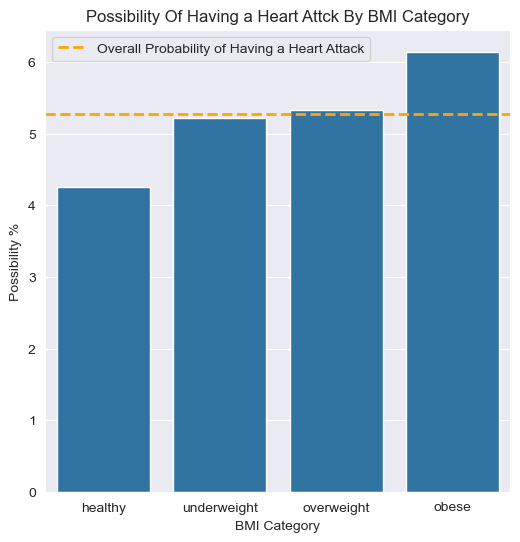

In [11]:
# Plot the likelihood of having a heart attack by bmi_category
plt.figure(figsize=(6, 6))

# Plot the likelihood of having a heart attack by each bmi_category
sns.barplot(x='bmi_category', y='Yes', data=bmi_likelihood_df.sort_values(by='Yes') )

# Plot the horizontal line of Overall probability of having a heart attack
plt.axhline(y=p_heart_attack, 
            ls='--', 
            lw=2, 
            color='orange', 
            label='Overall Probability of Having a Heart Attack'
            )
plt.title('Possibility Of Having a Heart Attck By BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Possibility %')
plt.xticks(rotation=0)
plt.legend()

plt.show()

**Takeaways**:
- The likelihood of having a heart attack differs across various BMI categories. The 'healthy' group shows a notably lower likelihood of experiencing a heart attack, while the 'obese' group exhibits a higher likelihood.
- Consequently, I will add a new feature, `bmi_category` to to categorize the `bmi` values.

In [12]:
# Create bmi_category column
bmi_category = df['bmi'].apply(get_bmi_bin)

# Insert the column into 8th position
df.insert(loc=8, column='bmi_category', value=bmi_category)

# Check the head of df
df.head()

,year,sex,race_ethnicity_category,age_category,state,height,weight,bmi,bmi_category,alcohol_drinkers,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,Female,White,80+,Alabama,1.60,78.02,30.48,obese,No,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,No
1,2022,Female,White,80+,Alabama,1.45,59.87,28.48,overweight,No,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,No
2,2022,Female,Black,80+,Alabama,1.63,58.97,22.20,healthy,No,...,Yes,Yes,No,No,Past year,not_asked,Yes,not_asked,Yes,No
3,2022,Female,White,75-79,Alabama,1.68,77.11,27.32,overweight,No,...,Yes,No,No,No,Past 2-5 years,not_asked,Yes,not_asked,Yes,No
4,2022,Female,White,75-79,Alabama,1.73,77.11,25.76,overweight,Yes,...,Yes,Yes,No,Yes,Past year,not_asked,No,not_asked,Yes,No


In [13]:
# Sanity Check
df['age_category'].isna().sum()

0

---

## 3. Data Preparation  <a class="anchor" id="3"></a>

### 3.1 Binary Encoding <a class="anchor" id="3a"></a>

Transform binary columns into 1 and 0.

In [14]:
# Create a copy of df
df_encoded = df.copy()

Fetch binary columns, and print unique values within each binary column.

In [15]:
# Create an empty list
binary_cols = []

# Iterate each column, find the one that are both binary and categorical
for col in df.columns:
    if (df[col].nunique() == 2) & (df[col].dtype == 'object'):
        print(f'Column Name: {col}')
        print(f'Unique Values: {df[col].unique()}')
        print('----' * 8)

        # Append to the list
        binary_cols.append(col)



Column Name: sex
Unique Values: ['Female' 'Male']
--------------------------------
Column Name: physical_activities
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_angina
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_stroke
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_asthma
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_heart_attack
Unique Values: ['No' 'Yes']
--------------------------------


Most of the columns are 'Yes' and 'No' column, I will create dictionaries for mapping these columns into 1 and 0. Before encoding, I will first check the top for rows in df_encoded DataFrame.

In [16]:
# Check the head of df_encoded
df_encoded[binary_cols].head()

,sex,physical_activities,had_angina,had_stroke,had_asthma,had_heart_attack
0,Female,No,No,No,No,No
1,Female,Yes,No,No,No,No
2,Female,Yes,No,No,Yes,No
3,Female,Yes,No,No,No,No
4,Female,Yes,No,No,No,No


In [17]:
# Create dictionaries for mapping
yes_no = {
    'Yes' : 1,
    'No' : 0
}

is_female = {
    'Female' : 1,
    'Male' : 0
}

In [18]:
# Turn binary columns into binary values
for col in binary_cols:

    if col == 'sex': 
        df_encoded[col] = df_encoded[col].map(is_female)  # If the column is sex, use is_female for map
    else:
        df_encoded[col] = df_encoded[col].map(yes_no)   # Use yes_no for mapping other binary columns

In [19]:
# Sanity check
df_encoded[binary_cols].head()

,sex,physical_activities,had_angina,had_stroke,had_asthma,had_heart_attack
0,1,0,0,0,0,0
1,1,1,0,0,0,0
2,1,1,0,0,1,0
3,1,1,0,0,0,0
4,1,1,0,0,0,0


The binary encoding is successfully executed, I will rename `sex` to `is_female` for interpretation purpose. 

In [20]:
# Rename sex column
df_encoded = df_encoded.rename(columns={'sex' : 'is_female'})

In [21]:
# Sanity check
df_encoded.head(2)

,year,is_female,race_ethnicity_category,age_category,state,height,weight,bmi,bmi_category,alcohol_drinkers,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,1,White,80+,Alabama,1.60,78.02,30.48,obese,No,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,0
1,2022,1,White,80+,Alabama,1.45,59.87,28.48,overweight,No,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,0


---

### 3.2 Train-Validation-Test-Split   <a class="anchor" id="3b"></a>

In [22]:
# Load the data and split into X and y
X = df_encoded.loc[:, df_encoded.columns != 'had_heart_attack']
y = df_encoded['had_heart_attack']

In [23]:
# Check shape
print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

Shape of X is (751985, 37)
Shape of y is (751985,)


In [24]:
# Remainder test split
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [25]:
# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, stratify=y_remainder, test_size=0.3, random_state=1)

In [26]:
# Print the size and target varaible distribution
print(f'X_train shape: {X_train.shape}')
print(f'Percentage of rows had heart attack (train set) {(y_train.mean()):.2%}')

print(f'X_validation shape: {X_val.shape}')
print(f'Percentage of rows had heart attack (validation set) {(y_val.mean()):.2%}')

print(f'X_test shape: {X_test.shape}')
print(f'Percentage of rows had heart attack (test set) {(y_test.mean()):.2%}')

X_train shape: (421111, 37)
Percentage of rows had heart attack (train set) 5.28%
X_validation shape: (180477, 37)
Percentage of rows had heart attack (validation set) 5.28%
X_test shape: (150397, 37)
Percentage of rows had heart attack (test set) 5.28%


**Overview of Train, Validation, and Test set**:

| Dataset     | Rows | Cols | Percentage of Had Heart Attack |
|-------------|------|------|---------------------------------|
| Train       | 421111| 37 + 1   | 5.28%                             |
| Validation   | 180477 | 37 + 1   | 5.28%                            |
| Test        | 150397 | 37 + 1  | 5.28%                             |

---

### 3.3 Log Transformation of Non-Normal Features <a class="anchor" id="3c"></a>

Based on the findings on preliminary EDA, I found that both `physical_health_days` and `mental_heanlth_days` have extremely right-skewed, non-normal distribution. In this section 

In [ ]:
# 

In [ ]:
# Recap of distributions

### 3.3 One-Hot Encoding <a class="anchor" id="3c"></a>

In [27]:
# Get the categorical and numeric columns
categorcal_columns = X_train.select_dtypes(include='object').columns.tolist()
numeric_columns = X_train.select_dtypes(include='number').columns.tolist()


In [28]:
# Calculate the sum of unique categories for all categorical columns
# Create a variable to store the cum sum and set zero
cumsum_categories = 0

for col in categorcal_columns:
    cumsum_categories += X_train[col].nunique()

print(f'Total number of categorical columns: {len(categorcal_columns)}. ')
print(f'Total number of unique categories within each categorical column: {cumsum_categories}. ')

Total number of categorical columns: 26. 
Total number of unique categories within each categorical column: 164. 


In [29]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit transform the X_train categorical variables to array
encoded_array_train = encoder.fit_transform(X_train[categorcal_columns])

# Convert from arrary to DataFrame
encoded_df_train = pd.DataFrame(
    encoded_array_train, 
    columns=encoder.get_feature_names_out(categorcal_columns),
    index=X_train.index)


In [30]:
# Check encoded_df shape
print(f'After dropping one column within each categorical column, there should be 164 - 26 = {164-26} columns.')
print(f'The shape of one-hot-encoding DataFrame encoded_df: {encoded_df_train.shape}')

After dropping one column within each categorical column, there should be 164 - 26 = 138 columns.
The shape of one-hot-encoding DataFrame encoded_df: (421111, 138)


In [31]:
# Concatenate with encoded df
X_train_encoded = pd.concat([X_train[numeric_columns], encoded_df_train], axis=1)

In [32]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_train.shape[0] == X_train_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
expected_column_count = len(numeric_columns) + cumsum_categories - len(categorcal_columns)
same_cols = (expected_column_count == X_train_encoded.shape[1])

# Print sanity check results
print(f'If X_train and X_train_encoded has same rows: {same_rows}')
print(f'If X_train_encoded has expected number of columns ({expected_column_count}): {same_rows}')

If X_train and X_train_encoded has same rows: True
If X_train_encoded has expected number of columns (149): True


The rows and columns on Train data after One Hot Encoding is consistent with expectations, I will now work on transformation of validation and test data.


In [33]:
# Transform X_val
encoded_array_val = encoder.transform(X_val[categorcal_columns])

# Convert array into DataFrame
encoded_df_val = pd.DataFrame(
    encoded_array_val, 
    columns=encoder.get_feature_names_out(categorcal_columns),
    index=X_val.index
    )

# Concatenate encoded_df_val with X_val numeric columns
X_val_encoded = pd.concat([X_val[numeric_columns], encoded_df_val], axis=1)

In [34]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_val.shape[0] == X_val_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
expected_column_count = len(numeric_columns) + (cumsum_categories - len(categorcal_columns))
same_cols = (expected_column_count == X_val_encoded.shape[1])

# Print sanity check results
print(f'If X_val and X_val_encoded has same rows: {same_rows}')
print(f'If X_val_encoded has expected number of columns ({expected_column_count}): {same_rows}')

If X_val and X_val_encoded has same rows: True
If X_val_encoded has expected number of columns (149): True


In [35]:
# Transform X_test
encoded_array_test = encoder.transform(X_test[categorcal_columns])

# Convert array into DataFrame
encoded_df_test = pd.DataFrame(
    encoded_array_test, 
    columns=encoder.get_feature_names_out(categorcal_columns),
    index=X_test.index
    )

# Concatenate encoded_df_test with X_test numeric columns
X_test_encoded = pd.concat([X_test[numeric_columns], encoded_df_test], axis=1)

In [36]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_test.shape[0] == X_test_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
expected_column_count = len(numeric_columns) + (cumsum_categories - len(categorcal_columns))
same_cols = (expected_column_count == X_test_encoded.shape[1])

# Print sanity check results
print(f'If X_test and X_test_encoded has same rows: {same_rows}')
print(f'If X_test_encoded has expected number of columns ({expected_column_count}): {same_rows}')

If X_test and X_test_encoded has same rows: True
If X_test_encoded has expected number of columns (149): True


One hot encoding has successfully been implemented on X_trian and X_test.

---

### 3.4 Handling Class Imbalance  <a class="anchor" id="3d"></a>


The target variable in this dataset is highly imbalanced, which can pose challenges during training and evaluation. In this section, I will use both upsampling and downsampling techniques to rebalance the training data.

**Upsampling**

In [37]:
# Print number of class 1 and 0 sample before upsampling
print(f'Number of Class 1 samples before upsampling: {y_train.sum()}')
print(f'Number of Class 0 samples before upsampling: {y_train[y_train == 0].shape[0]}')

# Randomly duplicate class 1 observations
X_duplicate_positive, y_duplicate_positive = resample(
    X_train_encoded[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=X_train_encoded[y_train==0].shape[0],
    random_state=1
)

# Combine upsample with original data
X_train_upsampled = np.vstack((X_train_encoded[y_train == 0], X_duplicate_positive))
y_train_upsampled = np.hstack((y_train[y_train == 0], y_duplicate_positive))

# Print the number of class in after upsampling
print(f"\nNumber of Class 1 samples after upsampling: {y_train_upsampled.sum()}")
print(f"Number of Class 0 samples after upsampling: {y_train_upsampled.shape[0] - y_train_upsampled.sum()}")


Number of Class 1 samples before upsampling: 22222
Number of Class 0 samples before upsampling: 398889

Number of Class 1 samples after upsampling: 398889
Number of Class 0 samples after upsampling: 398889


**Downsampling**
#

In [38]:
# Print the number of class 0 and class 1 sample before downsampling
print(f'Number of Class 0 sample before upsampling {y_train[y_train==0].shape[0]}')
print(f'Number of Class 1 sample before upsampling {y_train.sum()}')

# Randomly remove negative class 0 observations
X_remove_negative, y_remove_negative = resample(
    X_train_encoded[y_train == 0],
    y_train[y_train == 0],
    replace=True,
    n_samples=X_train_encoded[y_train == 1].shape[0],
    random_state=1
)

# Combine downsample with original dataset
X_train_downsampled = np.vstack((X_train_encoded[y_train==1], X_remove_negative))
y_train_downsampled = np.hstack((y_train[y_train == 1], y_remove_negative))

# Print the number of class in after downsampling
print(f'Number of Class 0 sample after upsampling {y_train_downsampled[y_train_downsampled==0].shape[0]}')


Number of Class 0 sample before upsampling 398889
Number of Class 1 sample before upsampling 22222
Number of Class 0 sample after upsampling 22222


---

### 3.5 Feature Scaling  <a class="anchor" id="3e"></a>

Standard scaling on original dataset.

In [39]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train_encoded)

# Transform X_train X_val X_test
X_train_scaled = scaler.transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

Standard scaling on upsampling dataset

In [40]:
# Instantiate StandardScaler
scaler_upsampled = StandardScaler()

# Fit the scaler
scaler_upsampled.fit(X_train_upsampled)

# Transform X_train X_val X_test
X_train_scaled_upsampled = scaler.transform(X_train_upsampled)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

Standard scaling on downsampling dataset

In [41]:
# Instantiate StandardScaler
scaler_downsampled = StandardScaler()

# Fit the scaler
scaler_downsampled.fit(X_train_downsampled)

# Transform X_train X_val X_test
X_train_scaled_downsampled = scaler.transform(X_train_downsampled)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

---

### 3.6 Feature Selection <a class="anchor" id="3f"></a>

By this stage, I will first not do any feature selection.

---

### 3.7 Reducing Dimensionality using PCA  <a class="anchor" id="3g"></a>

In [42]:
# Get the shape of X_train
print(f'The dimension of X_train_scaled is: {X_train_scaled_upsampled.shape}')

The dimension of X_train_scaled is: (797778, 149)


Find and plot the cumulative sum of variance explained by PC.

In [43]:
# Instantiate PCA with 
initial_pca = PCA(n_components=0.9)

# Fit PCA
initial_pca.fit(X_train_scaled)

# Transform
X_train_pca = initial_pca.transform(X_train_scaled)
X_val_pca = initial_pca.transform(X_val_scaled)
X_test_pca = initial_pca.transform(X_test_scaled)

In [44]:
# Get the number 
num_pc = initial_pca.n_components_

# Calculate the cumsum of explained variance
cumsum_pca = initial_pca.explained_variance_ratio_.cumsum()

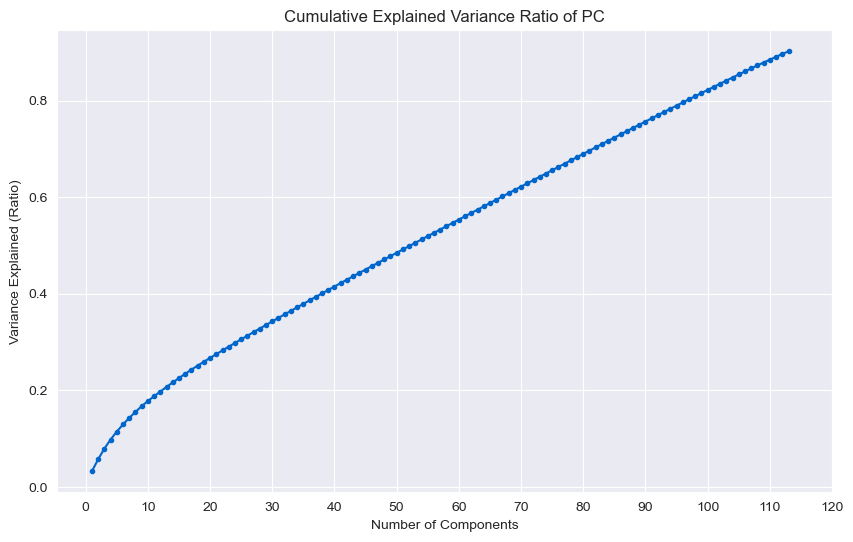

In [45]:
# Plot the cumsum of variance explained
plt.figure(figsize=(10,6))
plt.plot(range(1, num_pc+1), cumsum_pca, marker='.', c='#0066CC')
plt.title('Cumulative Explained Variance Ratio of PC')
plt.ylabel('Variance Explained (Ratio)')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, num_pc+10, 10))

plt.show()

---

## 4. Baseline Modeling  <a class="anchor" id="4"></a>

### 1 Logistic Regression  <a class="anchor" id="4a"></a>

#### 1.1 Logistic Regression Original (without unsampling, scaling or PCA)

In [65]:
y.value_counts()

had_heart_attack
0    712302
1     39683
Name: count, dtype: int64

Train: 0.95


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

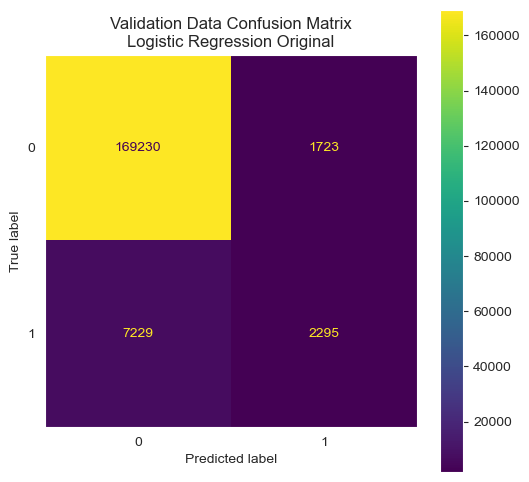

Validation Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    170953
           1       0.57      0.24      0.34      9524

    accuracy                           0.95    180477
   macro avg       0.77      0.62      0.66    180477
weighted avg       0.94      0.95      0.94    180477

Accuracy Score:
Train: 0.950
Validation: 0.950 
Precision Score:
Train: 0.570
Validation: 0.571 
Recall Score:
Train: 0.240
Validation: 0.241 
F1 Score:
Train: 0.338
Validation: 0.339 
AUC Score:
Train: 0.615
Validation: 0.615 


In [62]:
###############
#MODEL FITTING#
###############

# Original Data
logit_original = LogisticRegression(max_iter=1000, random_state=42)
logit_original.fit(X_train_encoded, y_train)
y_pred_train = logit_original.predict(X_train_encoded)
y_pred_val = logit_original.predict(X_val_encoded)


##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_original, X_val_encoded, y_val)
plt.title('Validation Data Confusion Matrix\nLogistic Regression With Imbalanced Class')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_val, y_pred_val)
print('Validation Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Validation: {accuracy_score(y_val, y_pred_val):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Validation: {precision_score(y_val, y_pred_val):.3f}', print_line)

# Print recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Validation: {recall_score(y_val, y_pred_val):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Validation: {f1_score(y_val, y_pred_val):.3f}', print_line)


# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_train):.3f}')
print(f'Validation: {roc_auc_score(y_val, y_pred_val):.3f}', print_line)


#### 1.2 Logistic Regression Upsampled (without scaling or PCA)

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

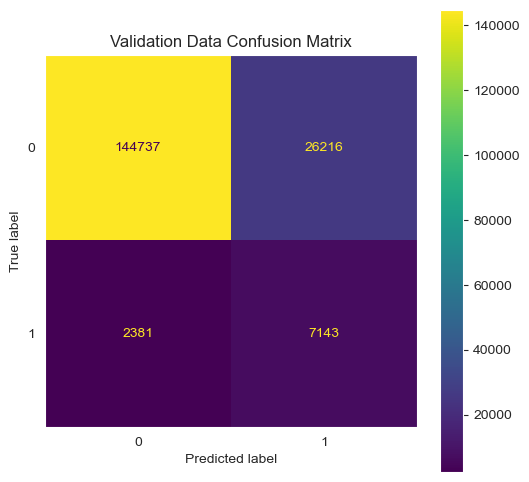

Validation Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.85      0.91    170953
           1       0.21      0.75      0.33      9524

    accuracy                           0.84    180477
   macro avg       0.60      0.80      0.62    180477
weighted avg       0.94      0.84      0.88    180477

Accuracy Score:
Train: 0.798
Validation: 0.842 
Precision Score:
Train: 0.831
Validation: 0.214 
Recall Score:
Train: 0.747
Validation: 0.750 
F1 Score:
Train: 0.787
Validation: 0.333 
AUC Score:
Train: 0.798
Validation: 0.798 


In [61]:
###############
#MODEL FITTING#
###############

# Original Data
logit_upsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled.fit(X_train_upsampled, y_train_upsampled)
y_pred_train_upsampled = logit_upsampled.predict(X_train_upsampled)
y_pred_val = logit_upsampled.predict(X_val_encoded)


##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_upsampled, X_val_encoded, y_val)
plt.title('Validation Data Confusion Matrix\nLogistic Regression With Upsampling')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_val, y_pred_val)
print('Validation Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Validation: {accuracy_score(y_val, y_pred_val):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Validation: {precision_score(y_val, y_pred_val):.3f}', print_line)

# Print recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Validation: {recall_score(y_val, y_pred_val):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Validation: {f1_score(y_val, y_pred_val):.3f}', print_line)


# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Validation: {roc_auc_score(y_val, y_pred_val):.3f}', print_line)

#### 1.3 Logistic Regression downsampled (without scaling or PCA)

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

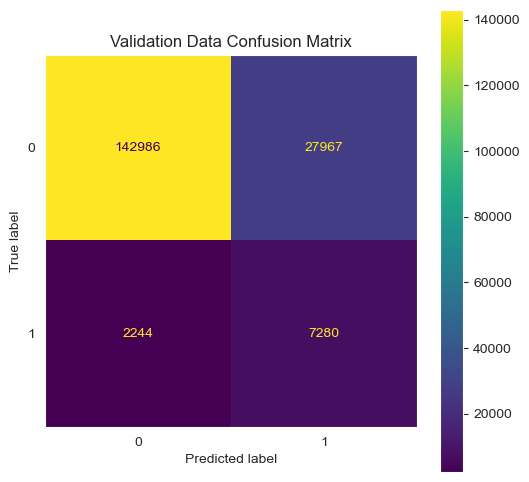

Validation Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    170953
           1       0.21      0.76      0.33      9524

    accuracy                           0.83    180477
   macro avg       0.60      0.80      0.61    180477
weighted avg       0.94      0.83      0.87    180477

Accuracy Score:
Train: 0.802
Validation: 0.833 
Precision Score:
Train: 0.827
Validation: 0.207 
Recall Score:
Train: 0.763
Validation: 0.764 
F1 Score:
Train: 0.794
Validation: 0.325 
AUC Score:
Train: 0.802
Validation: 0.800 


In [ ]:
###############
#MODEL FITTING#
###############

# Original Data
logit_downsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_downsampled.fit(X_train_downsampled, y_train_downsampled)
y_pred_train_downsampled = logit_downsampled.predict(X_train_downsampled)
y_pred_val = logit_downsampled.predict(X_val_encoded)


##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_downsampled, X_val_encoded, y_val)
plt.title('Validation Data Confusion Matrix\nLogistic Regression With Upsampling')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_val, y_pred_val)
print('Validation Data classification report: ', print_line, report_original)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Validation: {accuracy_score(y_val, y_pred_val):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Validation: {precision_score(y_val, y_pred_val):.3f}', print_line)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Validation: {recall_score(y_val, y_pred_val):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Validation: {f1_score(y_val, y_pred_val):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Validation: {roc_auc_score(y_val, y_pred_val):.3f}', print_line)

| Model                   | Train/Validation/Test | Accuracy | Precision | Recall | F1 Score | AUC   | Notes                       |
|-------------------------|----------------------|----------|-----------|--------|----------|-------|-----------------------------|
| Logistic Regression   | Validation | 0.95   | 0.571    | 0.241 | 0.339     | 0.615        | Original (imbalanced class)       |
| Logistic Regression   | Validation | 0.842   | 0.214    | 0.75 | 0.333     | 0.798        | Upsampled       |
| Logistic Regression   | Validation |0.833     | 0.207   | **0.764**   | 0.325    | 0.800       | Downsampled       |

---

### 2 Naive Bayes  <a class="anchor" id="4b"></a>